In [1]:
using DataFrames
using CSV
using Combinatorics
using SparseArrays
using Plots

In [3]:
S = [1,2]
A = [1,2]
lSl = length(S)
lAl = length(A)
R = zeros(lSl,lAl,lSl)
P = zeros(lSl,lAl,lSl)
df = DataFrame(idstatefrom=[],idaction=[],idstateto=[],probability=[],reward=[])
for s in S
    for a in A
        if s == 2
            temp = DataFrame(idstatefrom=s,idaction=a,idstateto=[1,2],probability=[0.8,0.2],reward=[0,0])
        else
            if a == 1
                temp = DataFrame(idstatefrom=s,idaction=a,idstateto=[1,2],probability=[0.8,0.2],reward=[-8,-8])
            else 
                temp = DataFrame(idstatefrom=s,idaction=a,idstateto=[1,2],probability=[0.8,0.2],reward=[12,-18])
            end
        end
        append!(df,temp)
    end
end
CSV.write("C:/GITHUB/rmdp-jl-2/data/easy2.csv", df)

"C:/GITHUB/rmdp-jl-2/data/easy2.csv"

In [4]:
# to avoid making a copy of parsed columns, use CSV.read
df = CSV.read("C:/GITHUB/rmdp-jl-2/data/easy2.csv", DataFrame)

# Convert a data frame to MDP.
function df2MDP(df;γ = 0.98)
    S = unique([df.idstatefrom;df.idstateto])
    A = unique(df.idaction)
    lSl = length(S)
    lAl = length(A)
    P = zeros((lSl,lAl,lSl))
    R = zeros((lSl,lAl,lSl))
    for i in eachrow(df)
        P[i.idstatefrom,i.idaction,i.idstateto] += i.probability
        R[i.idstatefrom,i.idaction,i.idstateto] += i.reward
    end
    return (S=S,A=A,P=P,R=R,lSl=lSl,lAl=lAl,γ=γ)
end

# Define a fixed discount and MDP

MDP = df2MDP(df;γ =0.9)

# Check if transition sum to "one"
# Correct value : 0.0
sum(abs.(sum(MDP.P,dims=3) .- 1.0))

0.0

In [5]:
# O(Nlog(N)) with sort
function distribution(X,p)
    d = DataFrame(X = X, p = p)
    d = d[d.p .> 0,:]
    d = combine(groupby(d, ["X"]),df -> DataFrame(p = sum(df.p)) ) 
    sort!(d,["X"]) 
    return d
end

# O(N) code for cumulative adding values
function cumulativeSum(V)
    N = length(V)
    Vsum = zeros(N)
    Vsum[1] = V[1]
    for i in 2:N
        Vsum[i] = Vsum[i-1] + V[i]
    end
    return Vsum
end

function delta(V)
   return [ V[1] ; V[Not(1)] - V[Not(length(V))]] 
end

# Fast CVaR function takes in a distribution (d) and a vector of risk (Alpha)
function CVaR(d,Alpha)
    # Set lambda 
    Lambda = 1 .- Alpha
    
    M = length(Alpha)
    N = nrow(d)
    output = zeros(M)
    j = 1
    
    # Here we precompute repeatedly used values, Psum and XTP.
    d.Psum = cumulativeSum(d.p)
    d.XTP = cumulativeSum(d.X .* d.p)
    
    # Special Case 1: if risk is 0 just use minimum
    while (j <= M) && (Lambda[j] == 0)
        output[j] = minimum(d[d.p .> 0,:].X)
        j+=1
    end  
    
    # General Case for i==1, d[i-1,:] is not valid
    while (j <= M) && (Lambda[j] <= d.Psum[1])
        output[j] = (d.X[1]*(Lambda[j]))/Lambda[j]
        j+=1
    end
    # General Cases
    for i in 2:N
        while (j <= M) && (Lambda[j] <= d.Psum[i])
            output[j] = (d.XTP[i-1] + d.X[i]*(Lambda[j] - d.Psum[i-1]))/Lambda[j]
            j+=1
        end
    end  
    
    while (j <= M)
        output[j] = d.XTP[N]
        j+=1
    end
    
    return output
end

function RtγV(R,γ,V,P) # distribution(X,p)
    return distribution(
        reduce(vcat,[rew .+ γ .* V[s].X for (s,rew) in enumerate(R)]),
        reduce(vcat,[prob .* V[s].p for (s,prob) in enumerate(P)]) )
end

function V_distribution(MDP,policy;T=10) 
    V = [[DataFrame() for s in MDP.S] for t in 1:(T+1)]
    V[T+1] = [DataFrame(X = [0], p = [1]) for s in MDP.S]
    for t in T:-1:1
        for s in MDP.S
            a = policy[t,s]
            V[t][s] = RtγV(MDP.R[s,a,:],MDP.γ,V[t+1],MDP.P[s,a,:])
        end
    end
    return V
end

function CVaR_MDP(MDP;T=10,M=10001)
    Alpha = LinRange(1,0,M)
    V = [[DataFrame() for s in MDP.S] for t in 1:(T+1)]
    V[T+1] = [DataFrame(X = [0], p = [1]) for s in MDP.S]
    V̂ = [zeros(MDP.lSl,M) for t in 1:T]
    π = [zeros(Int64,MDP.lSl,M) for t in 1:T]
    Q = [zeros(MDP.lSl,M,MDP.lAl) for t in 1:T]
    for t in T:-1:1
        for s in MDP.S
            for a in MDP.A
                Q[t][s,:,a] = CVaR(RtγV(MDP.R[s,a,:],MDP.γ,V[t+1],MDP.P[s,a,:]),Alpha)
            end
        end
        opt = findmax(Q[t],dims=3)
        V̂[t] = opt[1][:,:,1]
        π[t] = [i[3] for i in opt[2][:,:,1]]
        for s in MDP.S
            V[t][s] = CVaR2Distribution(V̂[t][s,:],Alpha)
        end
    end
    return (Q=Q,π=π,V=V,V̂=V̂)
end

function CVaR2Distribution( cvar , αs ; sig = 10)
    λ = 1 .- αs
    p = delta( λ )
    X = round.( delta( λ .* cvar ) ./ (p) ;sigdigits = sig)
    d = distribution(X,p)
    return d
end

CVaR2Distribution (generic function with 1 method)

In [6]:
M = 1001
T = 2
sol = CVaR_MDP(MDP;T=T,M=M)
@elapsed CVaR_MDP(MDP;T=T,M=M)

0.0044143

In [7]:
∀loc = [(i,j) for i in 1:T for j in MDP.S]
a2 = reduce(vcat,[collect(combinations(∀loc,i)) for i in 0:length(∀loc)])
function sparsePi(indexes,nRow,nCol)
    I = [i[1] for i in indexes]
    J = [i[2] for i in indexes]
    return(Array{Int8}(sparse(I,J,1,nRow,nCol)) .+ Int8(1)) 
end
Π∀ =[ sparsePi(act2,T,MDP.lSl) for act2 in a2]
nΠ∀ = length(Π∀)

16

In [8]:
Vπ = unique([ V_distribution(MDP,policy;T=T) for policy in Π∀])
Alpha = LinRange(1,0,M)
t = 1
Real_optimal_CVaR = [ reduce((x,y) -> max.(x,y), [CVaR(v[t][s],Alpha) for v in Vπ]) for s in MDP.S]
# Let just look at state 2 at time 1


2-element Vector{Vector{Float64}}:
 [-15.2, -15.2, -15.2, -15.200000000000001, -15.2, -15.2, -15.200000000000001, -15.2, -15.2, -15.2  …  10.206659939455097, 10.219354838709675, 10.23202416918429, 10.244668008048288, 10.257286432160805, 10.269879518072287, 10.282447342026078, 10.294989979959919, 10.307507507507507, 10.319999999999999]
 [-7.2, -7.2, -7.2, -7.2, -7.2, -7.200000000000001, -7.2, -7.2, -7.2, -7.2  …  4.261150353178608, 4.26774193548387, 4.274320241691843, 4.280885311871226, 4.287437185929648, 4.293975903614457, 4.300501504513541, 4.307014028056112, 4.313513513513513, 4.3199999999999985]

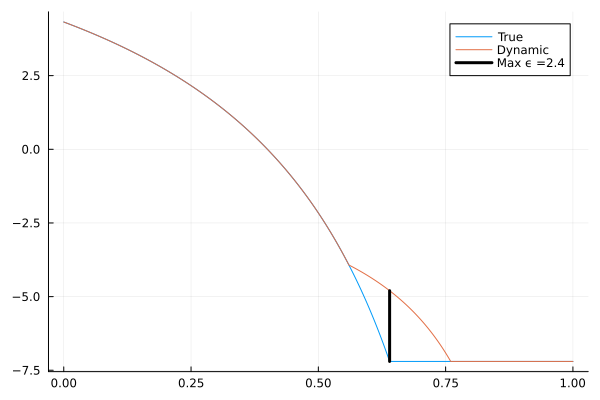

In [9]:
s=2
ErrMax = findmax(abs.(sol.V̂[t][s,:].-Real_optimal_CVaR[s]))
error = round(ErrMax[1],digits = 3)
plot(Alpha, [Real_optimal_CVaR[s], sol.V̂[t][s,:]],label = ["True" "Dynamic"])
plot!([Alpha[ErrMax[2]],Alpha[ErrMax[2]]],[sol.V̂[t][s,ErrMax[2]],Real_optimal_CVaR[s][ErrMax[2]]], linewidth=3,lc=:black , label = raw"Max ϵ ="*"$error")

From this discounted two-states, two-actions, two-timestep simple example, the CVaR with quantile discretization yield an error of $2.4$ which is $8\%$ of the range of reward $30 = r_\text{max} - r_\text{min}$ at risk level $\alpha = 0.64$.

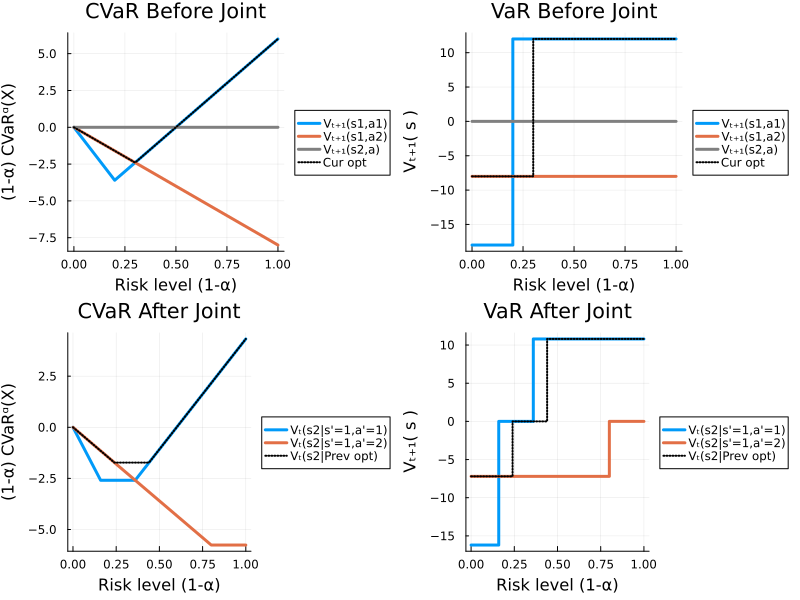

In [10]:
t = 2
t2_CVaR = [ unique( [ v[t][s] for v in Vπ] ) for s in MDP.S]
t2CVaRopt = [ reduce((x,y) -> max.(x,y),[ CVaR(D,Alpha) for D in t2_CVaR[s] ]) for s in MDP.S]
sd = 1
sr = 2
t2VaRopt = [ CVaR2Distribution( t2CVaRopt[s] , Alpha ) for s in MDP.S]
t2VaRopt[sd].Psum = cumulativeSum( t2VaRopt[sd].p )
ar1 = 1
ar2 = 1
al1 = 2
p1 = plot([0;t2_CVaR[sd][al1].Psum],[0;t2_CVaR[sd][al1].XTP],linewidth=3,label = "Vₜ₊₁(s1,a1)",legend=:outerright,title="CVaR Before Joint")
plot!(p1,[0;t2_CVaR[sd][ar1].Psum] , [0;t2_CVaR[sd][ar1].XTP],linewidth=3,label = "Vₜ₊₁(s1,a2)")
plot!(p1,[0;t2_CVaR[sr][ar2].Psum], [0;t2_CVaR[sr][ar2].XTP],linewidth=3,label = "Vₜ₊₁(s2,a)",lc=:grey)
plot!(p1, 1 .- Alpha,t2CVaRopt[sd] .* (1 .- Alpha),label="Cur opt" , linewidth=2,lc=:black,ls=:dot)
ylabel!(p1,"(1-α) CVaRᵅ(X)")
xlabel!(p1,"Risk level (1-α)")


p2 = plot([0;t2_CVaR[sd][al1].Psum],[t2_CVaR[sd][al1].X[1];t2_CVaR[sd][al1].X],linewidth=3,title="VaR Before Joint", linetype=:steppre,label = "Vₜ₊₁(s1,a1)",legend=:outerright)
plot!(p2,[0;t2_CVaR[sd][ar1].Psum] , [t2_CVaR[sd][ar1].X;t2_CVaR[sd][ar1].X],linewidth=3, linetype=:steppre,label = "Vₜ₊₁(s1,a2)")
plot!(p2,[0;t2_CVaR[sr][ar2].Psum] , [t2_CVaR[sr][ar2].X;t2_CVaR[sr][ar2].X],linewidth=3, linetype=:steppre,lc=:grey,label = "Vₜ₊₁(s2,a)")
# plot!(p2,[0.3,0.3],[-15,16],label = "α = 0.3", linewidth=3,lc=:black,ls=:dash)
plot!(p2,[0;t2VaRopt[sd].Psum],[t2VaRopt[sd].X[1];t2VaRopt[sd].X],label="Cur opt" , linetype=:steppre,linewidth=2,lc=:black,ls=:dot)
ylabel!(p2,"Vₜ₊₁( s )")
xlabel!(p2,"Risk level (1-α)")

    
t=1
s=2
t1s2_CVaR = unique( [ v[t][s] for v in Vπ] )
t1s2_optimistic = RtγV(MDP.R[2,1,:],MDP.γ,t2VaRopt,MDP.P[2,1,:])
t1s2_optimistic.Psum = cumulativeSum(t1s2_optimistic.p)
t1s2_optimistic.XTP = cumulativeSum(t1s2_optimistic.X .* t1s2_optimistic.p)
p3 = plot([0;t1s2_CVaR[2].Psum],[0;t1s2_CVaR[2].XTP],linewidth=3,title="CVaR After Joint",label = "Vₜ(s2|s'=1,a'=1)",legend=:outerright)
plot!(p3,[0;t1s2_CVaR[1].Psum] , [0;t1s2_CVaR[1].XTP],linewidth=3,label = "Vₜ(s2|s'=1,a'=2)")
plot!(p3, [0;t1s2_optimistic.Psum],[0;t1s2_optimistic.XTP],label="Vₜ(s2|Prev opt)" , linewidth=2,lc=:black,ls=:dot)
# plot!(p3,[.36,.36],[-12,18],label = "α = 0.3", linewidth=3,lc=:black,ls=:dash)
ylabel!(p3,"(1-α) CVaRᵅ(X)")
xlabel!(p3,"Risk level (1-α)")

p4 = plot([0;t1s2_CVaR[2].Psum],[t1s2_CVaR[2].X[1];t1s2_CVaR[2].X],linewidth=3,title="VaR After Joint", linetype=:steppre,label = "Vₜ(s2|s'=1,a'=1)",legend=:outerright)
plot!(p4,[0;t1s2_CVaR[1].Psum] , [t1s2_CVaR[1].X[1];t1s2_CVaR[1].X],linewidth=3, linetype=:steppre,label = "Vₜ(s2|s'=1,a'=2)")
plot!(p4,[0;t1s2_optimistic.Psum] , [t1s2_optimistic.X[1];t1s2_optimistic.X],label="Vₜ(s2|Prev opt)",linetype=:steppre, linewidth=2,lc=:black,ls=:dot)
ylabel!(p4,"Vₜ₊₁( s )")
xlabel!(p4,"Risk level (1-α)")

plot(p1, p2,p3, p4, layout=(2,2),size = (800, 600))
